# Problem Statement

Road Traffic Severity Classification

The target feature is Accident_severity which is a multi-class variable. The task is to classify this variable based on the other 31 features step-by-step by going through each day's task. Your metric for evaluation will be f1-score


# Importing libraries 

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold,GridSearchCV

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import KFold # import KFold

import warnings
warnings.filterwarnings('ignore')

# Data loading and reading the data

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/visalakshi2001/rta-severity-prediction/main/RTA%20Dataset.csv")
data.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


In [5]:
df = data.copy()
df.shape


(12316, 32)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment              12

In [10]:
# renaming columns
col_map={
    'Time': 'time',
    'Day_of_week': 'day_of_week',
    'Age_band_of_driver': 'driver_age',
    'Sex_of_driver': 'driver_sex',
    'Educational_level': 'educational_level',
    'Vehicle_driver_relation': 'vehicle_driver_relation',
    'Driving_experience': 'driving_experience',
    'Type_of_vehicle': 'vehicle_type',
    'Owner_of_vehicle': 'vehicle_owner',
    'Service_year_of_vehicle': 'service_year',
    'Defect_of_vehicle': 'vehicle_defect',
    'Area_accident_occured': 'accident_area',
    'Lanes_or_Medians': 'lanes',
    'Road_allignment': 'road_allignment',
    'Types_of_Junction': 'junction_type',
    'Road_surface_type': 'surface_type',
    'Road_surface_conditions': 'road_surface_conditions',
    'Light_conditions': 'light_condition',
    'Weather_conditions': 'weather_condition',
    'Type_of_collision': 'collision_type',
    'Number_of_vehicles_involved': 'vehicles_involved',
    'Number_of_casualties': 'casualties',
    'Vehicle_movement': 'vehicle_movement',
    'Casualty_class': 'casualty_class',
    'Sex_of_casualty': 'casualty_sex' , 
    'Age_band_of_casualty': 'casualty_age', 
    'Casualty_severity': 'casualty_severity',
    'Work_of_casuality': 'casualty_work', 
    'Fitness_of_casuality': 'casualty_fitness',
    'Pedestrian_movement': 'pedestrian_movement',
    'Cause_of_accident': 'accident_cause',
    'Accident_severity': 'accident_severity'
}
df.rename(columns=col_map, inplace=True)

In [11]:
# Checking for presecne of null values specifically in O/P as well as in the I/P features

df.isnull().sum()

time                          0
day_of_week                   0
driver_age                    0
driver_sex                    0
educational_level           741
vehicle_driver_relation     579
driving_experience          829
vehicle_type                950
vehicle_owner               482
service_year               3928
vehicle_defect             4427
accident_area               239
lanes                       385
road_allignment             142
junction_type               887
surface_type                172
road_surface_conditions       0
light_condition               0
weather_condition             0
collision_type              155
vehicles_involved             0
casualties                    0
vehicle_movement            308
casualty_class                0
casualty_sex                  0
casualty_age                  0
casualty_severity             0
casualty_work              3198
casualty_fitness           2635
pedestrian_movement           0
accident_cause                0
accident

In [14]:
#converting time to datetime
df['time'] = pd.to_datetime(df['time'])

# date (day-month-year) time
df["time"].dt.hour

0        17
1        17
2        17
3         1
4         1
         ..
12311    16
12312    18
12313    13
12314    13
12315    13
Name: time, Length: 12316, dtype: int64

In [15]:
df.describe(include=['O']).T

,count,unique,top,freq
day_of_week,12316,7,Friday,2041
driver_age,12316,5,18-30,4271
driver_sex,12316,3,Male,11437
educational_level,11575,7,Junior high school,7619
vehicle_driver_relation,11737,4,Employee,9627
driving_experience,11487,7,5-10yr,3363
vehicle_type,11366,17,Automobile,3205
vehicle_owner,11834,4,Owner,10459
service_year,8388,6,Unknown,2883
vehicle_defect,7889,3,No defect,7777


In [16]:
df.describe()

,vehicles_involved,casualties
count,12316.000000,12316.000000
mean,2.040679,1.548149
std,0.688790,1.007179
min,1.000000,1.000000
25%,2.000000,1.000000
50%,2.000000,1.000000
75%,2.000000,2.000000
max,7.000000,8.000000


In [17]:
# print duplicates
print("Number of duplicates: ", df.duplicated().sum())
print("Unique values per column:")
df.nunique()

Number of duplicates:  0
Unique values per column:


time                       1074
day_of_week                   7
driver_age                    5
driver_sex                    3
educational_level             7
vehicle_driver_relation       4
driving_experience            7
vehicle_type                 17
vehicle_owner                 4
service_year                  6
vehicle_defect                3
accident_area                14
lanes                         7
road_allignment               9
junction_type                 8
surface_type                  5
road_surface_conditions       4
light_condition               4
weather_condition             9
collision_type               10
vehicles_involved             6
casualties                    8
vehicle_movement             13
casualty_class                4
casualty_sex                  3
casualty_age                  6
casualty_severity             4
casualty_work                 7
casualty_fitness              5
pedestrian_movement           9
accident_cause               20
accident

# EDA

### Numerical data analysis

### Categorical data analysis

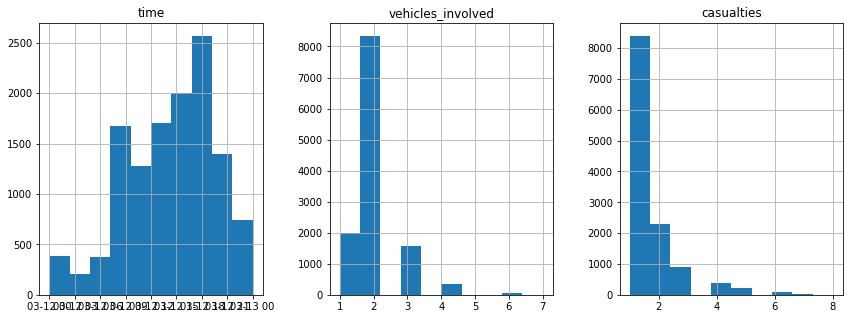

In [20]:
# Numerical data analysis 
df.hist(layout=(1,6), figsize=(30,5))
plt.show()

In [23]:
df['casualties'].value_counts()


1    8397
2    2290
3     909
4     394
5     207
6      89
7      22
8       8
Name: casualties, dtype: int64

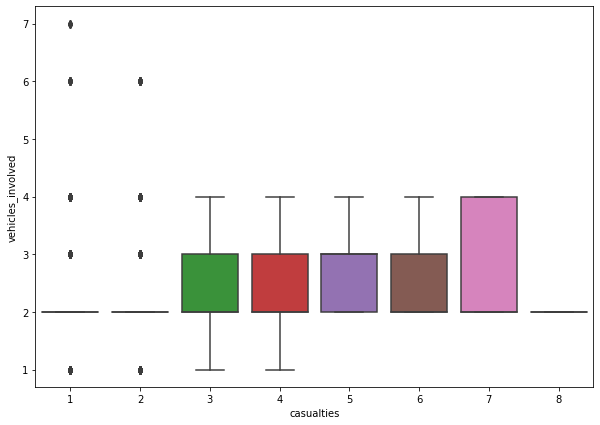

In [24]:
plt.figure(figsize=(10,7))
sns.boxplot(data=df, y='vehicles_involved', x='casualties')
plt.show()


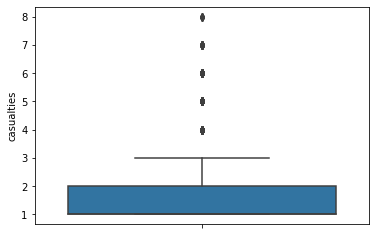

In [25]:
sns.boxplot(data=df, y='casualties')
plt.show()

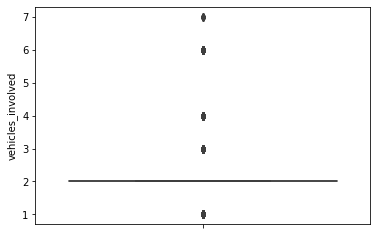

In [26]:
sns.boxplot(data=df, y='vehicles_involved')
plt.show()

In [27]:
df['vehicles_involved']


0        2
1        2
2        2
3        2
4        2
        ..
12311    2
12312    2
12313    1
12314    2
12315    2
Name: vehicles_involved, Length: 12316, dtype: int64

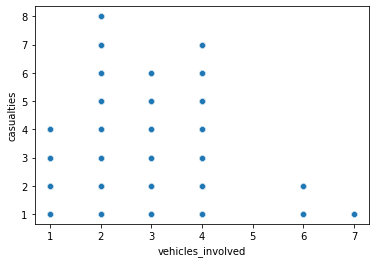

In [29]:
sns.scatterplot(x=df['vehicles_involved'], y=df['casualties'])
plt.show()

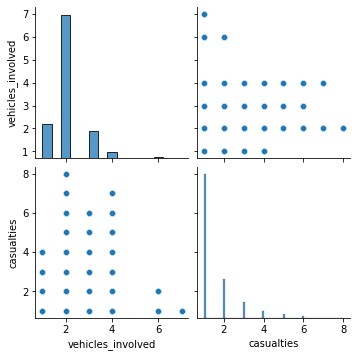

In [30]:
sns.pairplot(df[['vehicles_involved','casualties']])
plt.show()


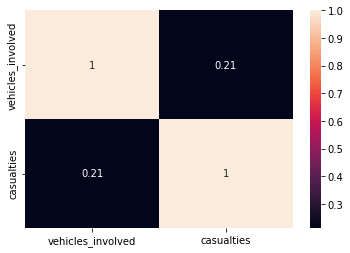

In [32]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

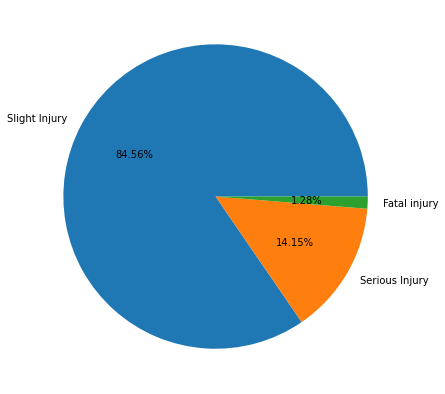

In [34]:
# Categorical data analysis

plt.figure(figsize=(10,7))
plt.pie(x=df['accident_severity'].value_counts().values,
        labels=df['accident_severity'].value_counts().index,
        autopct='%2.2f%%')
plt.show()


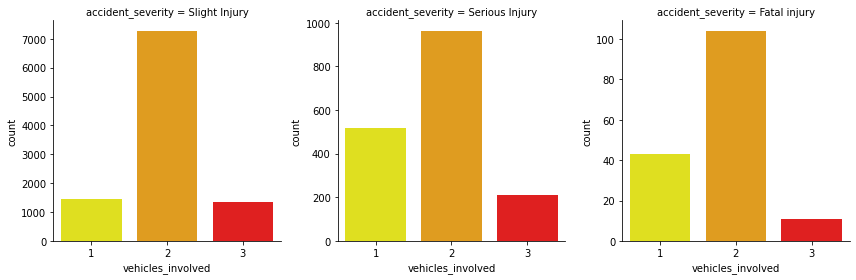

In [37]:
# creating a facet grid with columns as survived=0 and survived=1
grid = sns.FacetGrid(data=df, col='accident_severity', height=4, aspect=1, sharey=False)
# mapping bar plot and the data on to the grid
grid.map(sns.countplot, 'vehicles_involved', palette=['yellow', 'orange', 'red'])
plt.show()

# Data Preprocessing 

In [38]:
# dropping columns that can cause imbalance while imputation
lists = ['vehicle_driver_relation', 'casualty_work', 'casualty_fitness','day_of_week','casualty_severity','time','driver_sex','educational_level','vehicle_defect','vehicle_owner','service_year', 'surface_type','casualty_sex']
df.drop(columns = lists, inplace=True)


In [39]:
impute_cols = [x for x in df.isna().sum()[df.isna().sum() != 0].index.tolist()]
for feat in impute_cols:  
    mode = df[feat].mode()[0]
    df[feat].fillna(mode, inplace=True)

In [40]:
df.isnull().sum()


driver_age                 0
driving_experience         0
vehicle_type               0
accident_area              0
lanes                      0
road_allignment            0
junction_type              0
road_surface_conditions    0
light_condition            0
weather_condition          0
collision_type             0
vehicles_involved          0
casualties                 0
vehicle_movement           0
casualty_class             0
casualty_age               0
pedestrian_movement        0
accident_cause             0
accident_severity          0
dtype: int64

Class 0: 10415
Class 1: 1743
Proportion: 5.98 : 1


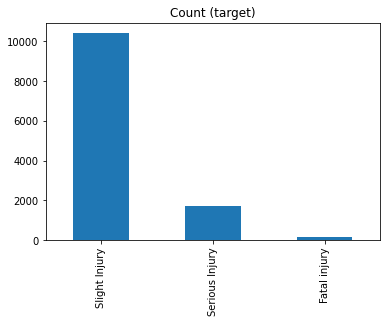

In [41]:
target_count = df['accident_severity'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [42]:
df.head()

,driver_age,driving_experience,vehicle_type,accident_area,lanes,road_allignment,junction_type,road_surface_conditions,light_condition,weather_condition,collision_type,vehicles_involved,casualties,vehicle_movement,casualty_class,casualty_age,pedestrian_movement,accident_cause,accident_severity
0,18-30,1-2yr,Automobile,Residential areas,Two-way (divided with broken lines road marking),Tangent road with flat terrain,No junction,Dry,Daylight,Normal,Collision with roadside-parked vehicles,2,2,Going straight,na,na,Not a Pedestrian,Moving Backward,Slight Injury
1,31-50,Above 10yr,Public (> 45 seats),Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Dry,Daylight,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,Not a Pedestrian,Overtaking,Slight Injury
2,18-30,1-2yr,Lorry (41?100Q),Recreational areas,other,Tangent road with flat terrain,No junction,Dry,Daylight,Normal,Collision with roadside objects,2,2,Going straight,Driver or rider,31-50,Not a Pedestrian,Changing lane to the left,Serious Injury
3,18-30,5-10yr,Public (> 45 seats),Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,Pedestrian,18-30,Not a Pedestrian,Changing lane to the right,Slight Injury
4,18-30,2-5yr,Automobile,Industrial areas,other,Tangent road with flat terrain,Y Shape,Dry,Darkness - lights lit,Normal,Vehicle with vehicle collision,2,2,Going straight,na,na,Not a Pedestrian,Overtaking,Slight Injury


In [52]:
from sklearn.preprocessing import LabelEncoder           #or one hot encoder
LE = LabelEncoder()
df=df.apply(LE.fit_transform)                            #categorical values to integers

<AxesSubplot:>

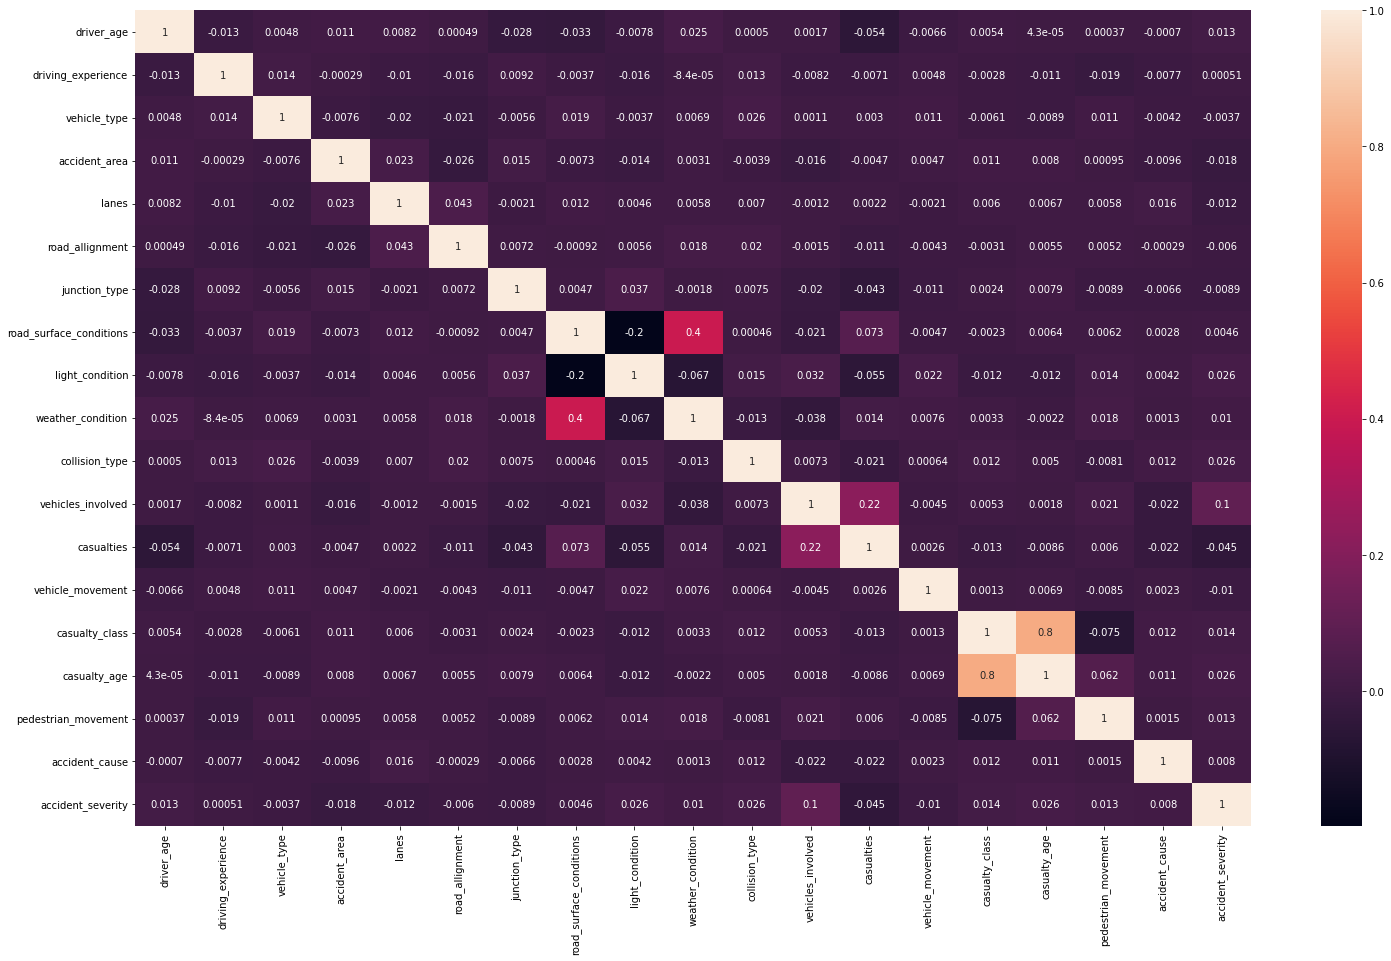

In [53]:
plt.figure(figsize=[25,15])
sns.heatmap(df.corr(),annot=True)

In [54]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 22:
        sns.countplot(y=col, data=df)

# Handling imbalance data 

#upsampling 

In [55]:
x = df.drop('accident_severity', axis=1)
y = df['accident_severity']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(8621, 18) (3695, 18) (8621,) (3695,)


In [56]:
# upsampling using smote

counter = Counter(ytrain)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(ytrain)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
xtrain, ytrain = oversample.fit_resample(xtrain, ytrain)

counter = Counter(ytrain)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(ytrain)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

print("=============================")

print("Upsampled data shape: ", xtrain.shape, ytrain.shape)

Class= 2, n=7324 (84.96%)
Class= 1, n=1191 (13.82%)
Class= 0, n=106 (1.23%)
Class= 2, n=7324 (33.33%)
Class= 1, n=7324 (33.33%)
Class= 0, n=7324 (33.33%)
Upsampled data shape:  (21972, 18) (21972,)


# Splitting test and train data

In [57]:
x=df.drop(columns=["accident_severity"])
y=df["accident_severity"]

# Model implementation 

In [58]:
models={"SVM":SVC(),
        "KNeighborsClassifier":KNeighborsClassifier(),
       "RandomForestClassifier":RandomForestClassifier(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "GradientBoostingClassifier":GradientBoostingClassifier(),
        }

In [59]:
# models,x,y,scaleFlag=0,1,2
def modelAccuracy(models,x,y,scaleFlag):
    #train/Test
    xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=0)
    acc_result={}
    for name,model in models.items():
        #pipeline
        #1.Transformer -> 2.Model
        if(scaleFlag==1):
            model_pipeline=Pipeline([('MinMaxScler',MinMaxScaler()),('model',model)])
        elif(scaleFlag==2):
             model_pipeline=Pipeline([('StandardScaler',StandardScaler()),('model',model)])
        else:
            model_pipeline=Pipeline([('model',model)])
        #training/testing on model pipeline
        model_fit=model_pipeline.fit(xtrain,ytrain)
        ypred=model_fit.predict(xtest)
        acc=accuracy_score(ytest,ypred)
        print("The Accuracy for ",name," is :",acc)
        acc_result[name]=acc
    return acc_result

In [60]:
def bestModel(result):
    high=0
    for name,acc in result.items():
        if acc>high:
            high=acc
            model_name=name
    print("Best Model is ",model_name," with accuaracy =>",high)

In [61]:
def bestParams(model,param,xtrain,ytrain):
    #cv
    cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=3)
    grid_cv=GridSearchCV(estimator=model,param_grid=param,cv=cv,scoring="f1_weighted")
    res=grid_cv.fit(xtrain,ytrain)
    print("Best Parameters are ",res.best_params_)
    print("Best Accuracy is ",res.best_score_)

In [62]:
bestParams


<function __main__.bestParams(model, param, xtrain, ytrain)>

In [63]:
acc=modelAccuracy(models,x,y,1)


The Accuracy for  SVM  is : 0.84375
The Accuracy for  KNeighborsClassifier  is : 0.8262987012987013
The Accuracy for  RandomForestClassifier  is : 0.8474025974025974
The Accuracy for  AdaBoostClassifier  is : 0.8425324675324676
The Accuracy for  GradientBoostingClassifier  is : 0.849025974025974


In [64]:
bestModel(acc)


Best Model is  GradientBoostingClassifier  with accuaracy => 0.849025974025974


In [65]:
model=RandomForestClassifier()
params={"n_estimators" : [100,200],
        "criterion" : ["gini","entropy"]
        }
bestParams(model,params,xtrain,ytrain)

Best Parameters are  {'criterion': 'entropy', 'n_estimators': 200}
Best Accuracy is  0.9192551440793078


In [66]:
#retrain the model with best parameters
model=RandomForestClassifier(criterion="entropy",n_estimators=200)
model.fit(xtrain,ytrain)
ypred=model.predict(xtest)

0.7683355886332882
              precision    recall  f1-score   support

           0       0.06      0.04      0.05        52
           1       0.23      0.18      0.20       552
           2       0.85      0.89      0.87      3091

    accuracy                           0.77      3695
   macro avg       0.38      0.37      0.37      3695
weighted avg       0.75      0.77      0.76      3695



<AxesSubplot:>

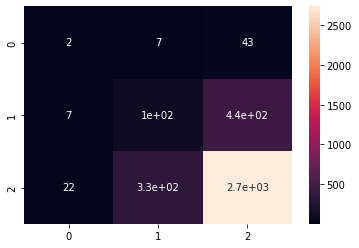

In [67]:
#Final Evaluation
print(accuracy_score(ytest,ypred))
print(classification_report(ytest,ypred))
cm=confusion_matrix(ytest,ypred)
sns.heatmap(cm,annot=True)